### 0. 讀取google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. 所有import的聚集地

In [ ]:
import os
import zipfile
import librosa
import numpy as np
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from matplotlib import pyplot as plt

### 2. 讀取訓練資料

In [ ]:
drivePath = '/content/drive/My Drive/course/數學軟體應用/final project/archive.zip'
local_zip = drivePath
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
baseDir = '/content/Data/genres_original/'
#genresList = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
genresList = ['classical', 'country', 'hiphop', 'jazz', 'rock']

In [ ]:
#@title Some unused code
hop_length = 512
y, sr = librosa.load('/content/Data/genres_original/blues/blues.00052.wav', duration=25.0)

y_harmonic, y_percussive = librosa.effects.hpss(y)
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)
#tempo = np.array(tempo).astype('float32')

mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc)
#beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]), beat_frames)
#beat_mfcc_delta = np.asarray(beat_mfcc_delta).astype('float32')

chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
#beat_chroma = librosa.util.sync(chromagram, beat_frames, aggregate=np.median)
#beat_chroma = np.asarray(beat_chroma).astype('float32')

zero_cross_rate = librosa.feature.zero_crossing_rate(y)
#zero_cross_rate = np.asarray(zero_cross_rate).astype('float32')
melspect = librosa.feature.melspectrogram(y=y, sr=sr)

#np.asarray([tempo, beat_chroma, beat_mfcc_delta, zero_cross_rate, melspect])


In [ ]:
#@title Some unused code
print(type(tempo), type(chromagram), type(mfcc_delta), type(zero_cross_rate), type(melspect))
print(tempo.shape, chromagram.shape, mfcc_delta.shape, zero_cross_rate.shape, melspect.shape)

In [ ]:
#@title Some unused code
def preprocessing(song_path):
  hop_length = 512
  y, sr = librosa.load(song_path, duration=25.0)

  y_harmonic, y_percussive = librosa.effects.hpss(y)
  tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr=sr)

  #mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)
  #mfcc_delta = librosa.feature.delta(mfcc)
  #beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]), beat_frames)
  #mfcc_delta = np.asarray(mfcc_delta).astype('float32')

  #chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
  #beat_chroma = librosa.util.sync(chromagram, beat_frames, aggregate=np.median)
  #beat_chroma = np.asarray(chromagram).astype('float32')

  #zero_cross_rate = librosa.feature.zero_crossing_rate(y)
  #zero_cross_rate = np.asarray(zero_cross_rate).astype('float32')
  melspect = librosa.feature.melspectrogram(y=y, sr=sr)

  #return [tempo, chromagram, mfcc_delta, zero_cross_rate, melspect]
  return [np.float32(tempo), melspect]


inputData = []
dataGenre = []
brokenData = ['jazz.00054.wav', '.ipynb_checkpoints']
for genre in genresList:
  if i == 2:
    break
  curDir = baseDir + genre
  fileNames = os.listdir(curDir)
  for song in fileNames:
    curFile = baseDir+genre+"/"+song
    #print(curFile)
    if song in brokenData:
      continue
    songFeature = preprocessing(curFile)
    inputData.append(songFeature)
    dataGenre.append(i)

In [ ]:
#@title Some unused code
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(inputData), np.array(dataGenre))
#X_train = preprocess_input(X_train)

#import tensorflow as tf
#tf.convert_to_tensor(X_train, dtype=tf.float32)
#y_train = to_categorical(y_train, 3)
#X_test = preprocess_input(X_test)
#y_test = to_categorical(y_test, 3)

from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()
y_train = label_as_binary.fit_transform(y_train)

model = models.Sequential([
                    layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),
                    layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),
                    layers.Flatten(),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(2, activation='softmax')])
#model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(3, 128, 391)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 1077)))
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(1, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10)#, batch_size=1, validation_data=(X_test, y_test))

### 3. 定義好function

In [ ]:
def minmax(X, min, max):
  X_std = (X - X.min()) / (X.max() - X.min())
  X_scaled = X_std * (max - min) + min
  return X_scaled

def cut_song(song):
  start = 0
  end = len(song)
  cutPoint = 200000
  song_pieces = []

  while start + cutPoint < end:
    song_pieces.append(song[start:start+cutPoint])
    start += cutPoint

  return song_pieces

def preprocess_song(song_path):
  list_matrices = []

  y, _ = librosa.load(song_path, duration=25.0)
  '''
  song_pieces = cut_song(y)

  for piece in song_pieces:
    melspect = librosa.feature.melspectrogram(piece)

    melspect = np.log(melspect + 1e-9) # add small number to avoid log(0)
    img = minmax(melspect, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0)
    list_matrices.append(img)
  
  return list_matrices
  '''
  melspect = librosa.feature.melspectrogram(y)
  melspect = np.log(melspect + 1e-9) # add small number to avoid log(0)
  img = minmax(melspect, 0, 255).astype(np.uint8)
  img = np.flip(img, axis=0)
  list_matrices.append(melspect)
  return melspect

def dataToRGB(data):
  plt.imshow(data, interpolation='none') # may be can try nearest

  frame = plt.gca()
  frame.axes.get_xaxis().set_visible(False)
  frame.axes.get_yaxis().set_visible(False)
  fig = frame.figure
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
  canvas = fig.canvas
  canvas.draw()
  data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
  image = data.reshape(canvas.get_width_height()[::-1] + (3,))
  return image

### 4. 把讀好的資料進行處理

In [ ]:
inputData = []
dataGenre = []
brokenData = ['jazz.00054.wav', '.ipynb_checkpoints']
i=0
for genre in genresList:
  curDir = baseDir + genre
  fileNames = os.listdir(curDir)
  for song in fileNames:
    curFile = baseDir+genre+"/"+song
    #print(curFile)
    if song in brokenData:
      continue
    songPieces = preprocess_song(curFile)
    inputData.append(dataToRGB(np.array(songPieces)))
    dataGenre.append(i)
  i += 1
print(i)

### 5. 把資料拆出訓練與測試資料

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(inputData), dataGenre, test_size=0.15)
X_train = preprocess_input(X_train)
y_train = to_categorical(y_train, 5)
X_test = preprocess_input(X_test)
y_test = to_categorical(y_test, 5)

### 6. 設置好模型

In [ ]:
from tensorflow.keras.applications import ResNet50V2
resnet = ResNet50V2(include_top=False, pooling="avg")
resnet.trainable = False

In [ ]:
model = models.Sequential()

model.add(resnet)
model.add(layers.Dense(5, activation='softmax'))

#model.summary()


### 7. 把資料丟進模型跑

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=33, epochs=23, validation_data=(X_test, y_test))

Epoch 1/23
13/13 [==============================] - 165s 12s/step - loss: 1.5862 - accuracy: 0.2476 - val_loss: 1.5241 - val_accuracy: 0.2267
Epoch 2/23
13/13 [==============================] - 163s 13s/step - loss: 1.3640 - accuracy: 0.4670 - val_loss: 1.2267 - val_accuracy: 0.5733
Epoch 3/23
13/13 [==============================] - 160s 12s/step - loss: 1.1873 - accuracy: 0.6061 - val_loss: 1.1255 - val_accuracy: 0.6533
Epoch 4/23
13/13 [==============================] - 161s 13s/step - loss: 1.0687 - accuracy: 0.6604 - val_loss: 1.0279 - val_accuracy: 0.6800
Epoch 5/23
13/13 [==============================] - 163s 13s/step - loss: 0.9902 - accuracy: 0.6722 - val_loss: 0.9674 - val_accuracy: 0.7200
Epoch 6/23
13/13 [==============================] - 166s 13s/step - loss: 0.9174 - accuracy: 0.7193 - val_loss: 0.9018 - val_accuracy: 0.7467
Epoch 7/23
13/13 [==============================] - 165s 13s/step - loss: 0.8642 - accuracy: 0.7453 - val_loss: 0.8884 - val_accuracy: 0.7200
Epoch 

### 手動測試

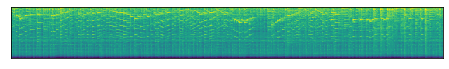

In [ ]:
input = '/content/Data/genres_original/jazz/jazz.00013.wav'
inp = preprocess_song(input)
data = np.array(dataToRGB(np.array(inp)))
d = preprocess_input(data)
prediction = model.predict(d.reshape(-1, 288, 432, 3)).flatten()

ans = []
for i in range(5):
  ans.append(float(prediction[i]))


In [ ]:
ans

[0.3374532163143158,
 0.33569395542144775,
 0.05142134800553322,
 0.15217211842536926,
 0.12325935810804367]

In [ ]:
score = model.evaluate(X_test, y_test)
print('loss:', score[0])
print('正確率', score[1])

4/4 [==============================] - 44s 11s/step - loss: 0.7283 - accuracy: 0.7440


### 模型儲存

In [ ]:
%cd '/content/drive/My Drive/course/數學軟體應用'

/content/drive/My Drive/course/數學軟體應用


In [ ]:
model.save('final_project_model_V2_test=0.15')

INFO:tensorflow:Assets written to: final_project_model_V2_test=0.15/assets


### 模型讀取

In [ ]:
model = models.load_model('final_project_model_V2_test=0.15')

### 圖形顯示

In [ ]:
genre = ['classical', 'country', 'hiphop', 'jazz', 'rock']

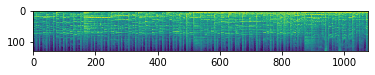

In [ ]:
input = '/content/Data/genres_original/rock/rock.00033.wav'
songPieces = preprocess_song(input)
img = np.array(songPieces)
plt.imshow(img, interpolation='none')

### gradio呈現

In [ ]:
!pip install gradio

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://44911.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(1, 288, 432, 3)
Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7eff76a9be50>,
 'http://127.0.0.1:7860/',
 'https://44911.gradio.app')

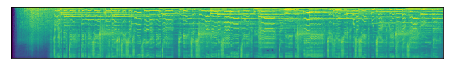

In [ ]:
import gradio as gr

def classify_music(Audio):
    songPieces = preprocess_song(Audio)
    songPieces = dataToRGB(np.array(songPieces))
    songPieces = preprocess_input(songPieces).reshape(1,288,432,3)
    print(songPieces.shape)
    prediction = model.predict(np.array(songPieces)).tolist()[0]
    class_name =['classical', 'country', 'hiphop', 'jazz', 'rock']
    return {class_name[i]: prediction[i] for i in range(5)}

Audio = gr.inputs.Audio(type = 'filepath')

gr.Interface(fn=classify_music, inputs=Audio, outputs=gr.outputs.Label()).launch(debug = True)